# PART 2 : GLM

2) Specify the experimental design matrix to use for this subject and include this matrix (as a figure) in your report.
3) Run the GLM at the level you deem reasonable and show the beta/statistical maps of each of your regressors.
4) Using the results of the GLM analysis and contrast vector of your choice, create the activation corresponding to the impact of positive against negative music. Please include the contrast you obtain, and report in which brain region you find maximal contrast based on AAL atlas parcellation.


In [ ]:
import pandas as pd
import numpy as np
from nilearn.glm.first_level import make_first_level_design_matrix
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix, plot_anat
from nilearn.glm.first_level import FirstLevelModel
import nibabel as nib

from nilearn.plotting import plot_contrast_matrix
import nibabel as nib
import os

from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img


In [62]:
# experimental design 
events_all = pd.DataFrame()

for id_run in range(3) : 
    events_files = f'gdrive_ds000171/ds000171/sub-control01/func/sub-control01_task-music_run-{id_run+1}_events.tsv'
    
    event = pd.read_csv(events_files, sep='\t')
    event.insert(0, 'run', f'run_{id_run+1}')
    
    events_all = pd.concat((events_all, event))

# remove the response time
events = events_all.query("trial_type != 'response'")

In [63]:
# Take the information from the json file to find TR
task_music_json = 'gdrive_ds000171/ds000171/task-music_bold.json'

import json

# Open and read the JSON file
with open(task_music_json, 'r') as file:
    info = json.load(file)

# Import TR
TR = info['RepetitionTime']

### FOR 1 RUN

In [64]:
event_run1 = events.query("run == 'run_1'")
event_run1 = event_run1.drop(columns = 'run')

In [65]:
event_run1

,onset,duration,trial_type
0,0.0,33.0,tones
2,36.0,31.5,negative_music
4,70.5,31.5,tones
6,105.0,31.5,positive_music
8,139.5,31.5,tones
10,174.0,31.5,negative_music
12,208.5,31.5,tones
14,243.0,31.5,positive_music
16,277.5,31.5,tones


In [66]:
t_start = 0
t_end = int(277.5 + 31.5)

In [67]:
frame_times= np.asarray(list(range(t_start, t_end, int(TR))))


In [68]:
design_matrix = make_first_level_design_matrix(
    frame_times=frame_times,
    events=event_run1,
    hrf_model='spm',
    drift_model= None,
)

<Axes: label='conditions', ylabel='scan number'>

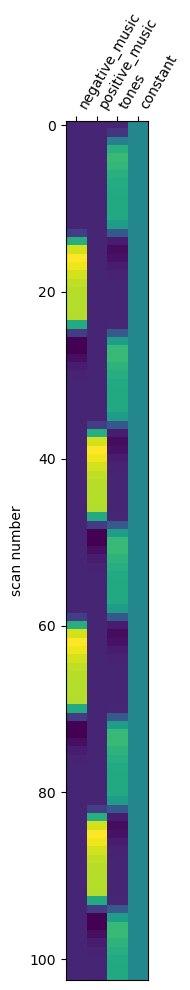

In [69]:
plot_design_matrix(design_matrix)

### FOR ALL RUNS

In [70]:
# Adjust the oneset for all the runs
duration_time ={}
for i in range(3) : 
    last_event = events_all[events_all['run'] == f'run_{i+1}'].tail(1)
    duration_time[i] = last_event['onset'].values + last_event['duration'].values

size_single_run =  len(events_all[events_all['run'] == f'run_1'])  # Here we takes the first but all of them are the same size

correction=[]
for i in range(3):  
    correction += [duration_time[i][0]*i]*size_single_run

events_all['onset'] += correction
# Drop the response recording  
events = events_all.query("trial_type != 'response'")
# Drop the index of the run
events = events.drop(columns = 'run')


In [71]:
t_start = events['onset'][0]
t_end =events.tail(1)['onset'] + events.tail(1)['duration']

frame_times= np.asarray(list(range(int(t_start.values[0]), int(t_end.values[0]), int(TR))))

Text(0.5, 1.0, 'Design Matrix for 3 Concatenated Runs')

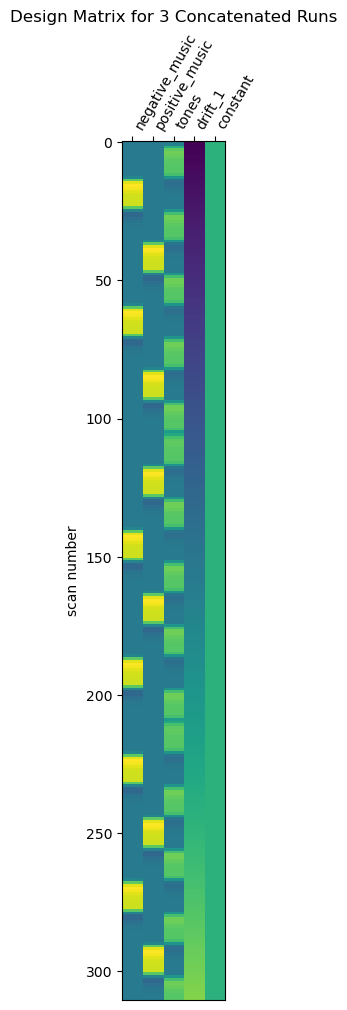

In [90]:
# Create design matrix using specified HRF model
design_matrix_conc = make_first_level_design_matrix(
    frame_times=frame_times,
    events=events,
    hrf_model='spm', # TODO
    drift_model='polynomial',  
    drift_order=1 
)

plot_design_matrix(design_matrix_conc)
plt.title("Design Matrix for 3 Concatenated Runs")

### GLM init

In [91]:
# Import data from preproc
data_path = 'sub_control01_preprocessed/func/concatenated_standardized_mc_smoothed.nii.gz'

fmri_img=nib.load(data_path)

In [92]:
from nilearn.glm.first_level import FirstLevelModel
drift_model = 'polynomial'  # Model to correct for slow signal drifts # TODO 
high_pass = 0.01  # High-pass filter cutoff, in Hz # TODO 

# Initialize the GLM model with drift correction and AR(1) noise model
fmri_glm = FirstLevelModel(
    t_r=TR,
    noise_model='ar1',
    standardize=False,
    hrf_model='spm',
    drift_model=drift_model,
    high_pass=high_pass, 
    drift_order=1
)

In [93]:
fmri_glm = fmri_glm.fit(fmri_img, events)

<Axes: label='conditions', ylabel='scan number'>

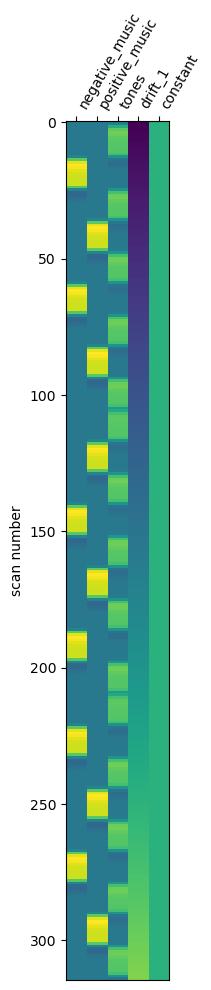

In [94]:
# we got the same matrix than previously
plot_design_matrix(fmri_glm.design_matrices_[0])

In [ ]:
# Create the dictionary of the conditions
conditions = {
    'neg_music' : np.array([1, 0, 0, 0 , 0]),
    'pos_music' : np.array([0, 1, 0, 0, 0]),
    'tones' : np.array([0, 0, 1, 0, 0]),
    'drift' : np.array([0, 0, 0, 1, 0])
}
# drift
drift = conditions['drift']

# Effect of negative musique 
neg_effect = conditions['tones'] - conditions['neg_music'] # TODO DRIFT

# Effect of positive musique 
pos_effect = conditions['tones'] - conditions['pos_music'] 

# positive versus negative musique
pos_neg = conditions['pos_music'] - conditions['neg_music'] 


In [96]:
# To got the names of the varriable - put in utile
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

for contrast in [neg_effect,pos_effect,pos_neg,drift] :
    print(namestr(contrast, globals()))


['neg_effect', 'contrast']
['pos_effect', 'contrast']
['pos_neg', 'contrast']
['drift', 'contrast']


In [ ]:
# First examine the drift to eventually correct the image
folder_state_path = 'derivatives/stats/z_maps'

# Plot the contrast map
plot_contrast_matrix(drift, design_matrix=fmri_glm.design_matrices_[0])
plt.title(namestr(drift, globals())[0])

# z map 
z_map = fmri_glm.compute_contrast(drift, output_type='z_score')

# plot z map 
mean_img_ = mean_img(fmri_img),
thr = 3

plot_stat_map(z_map, bg_img=mean_img_[0], threshold=thr,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title=f'Active minus Rest (Z>{thr})')

# TODO Lets remove it of all our contrasts

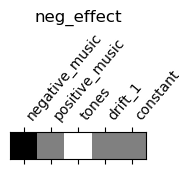

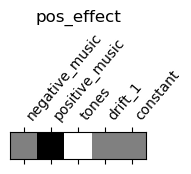

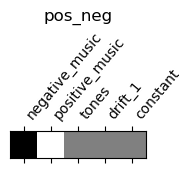

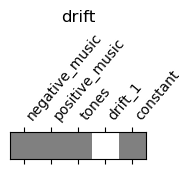

In [ ]:
# Create a directory to save the z_map
folder_state_path = 'derivatives/stats/z_maps'

if not os.path.exists(folder_state_path):
    os.makedirs(folder_state_path)

for contrast in [neg_effect,pos_effect,pos_neg]:
    # Plot the contrast map
    plot_contrast_matrix(contrast, design_matrix=fmri_glm.design_matrices_[0])
    plt.title(namestr(contrast, globals())[0])

    # z map 
    z_map = fmri_glm.compute_contrast(contrast, output_type='z_score')

    # Save the z_map uncorrected
    file_name = namestr(contrast, globals())[0] + '_z_map_uncorrected.nii.gz'
    nib.save(z_map, os.path.join(folder_state_path, file_name))



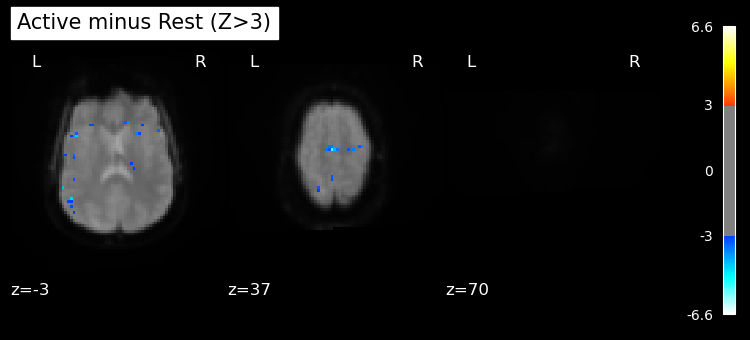

In [ ]:
# explore the z_map 
z_map = nib.load(os.path.join(folder_state_path, 'pos_neg_z_map_uncorrected.nii.gz'))
mean_img_ = mean_img(fmri_img),
thr = 3

plot_stat_map(z_map, bg_img=mean_img_[0], threshold=thr,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title=f'Active minus Rest (Z>{thr})')
plt.show()

## Statistical correction with fdr

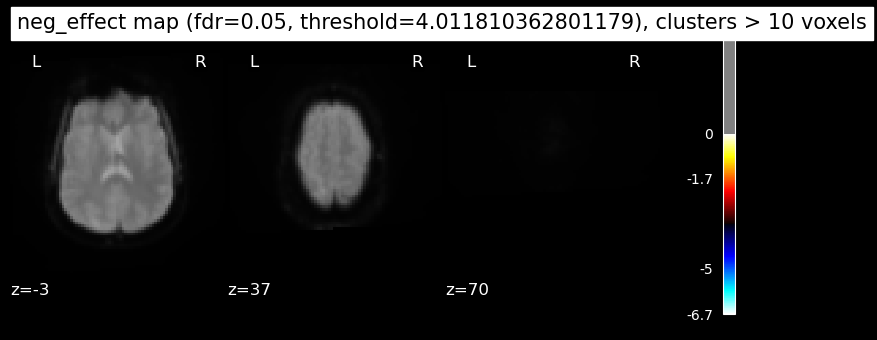

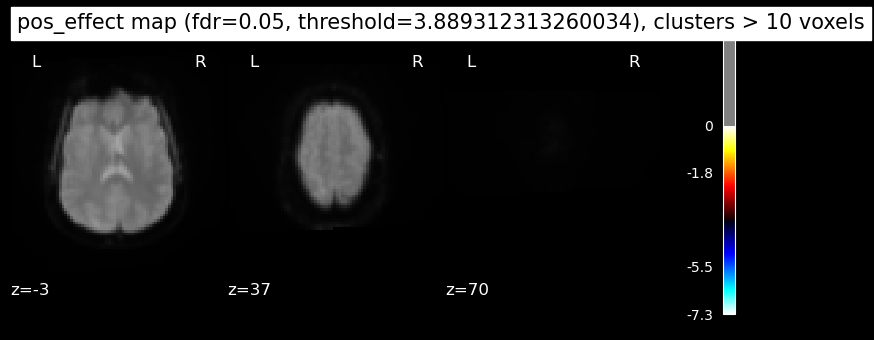

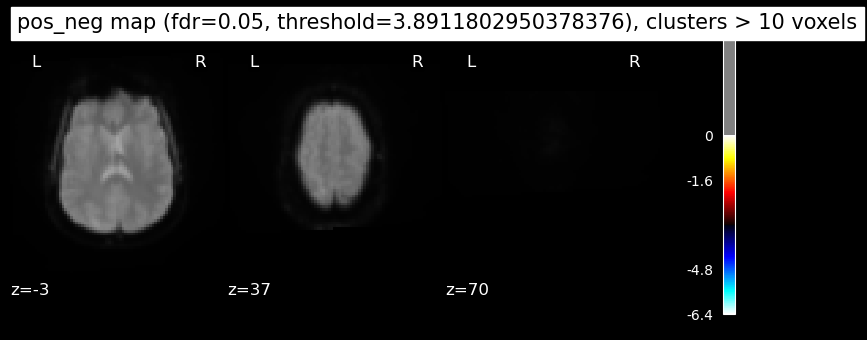

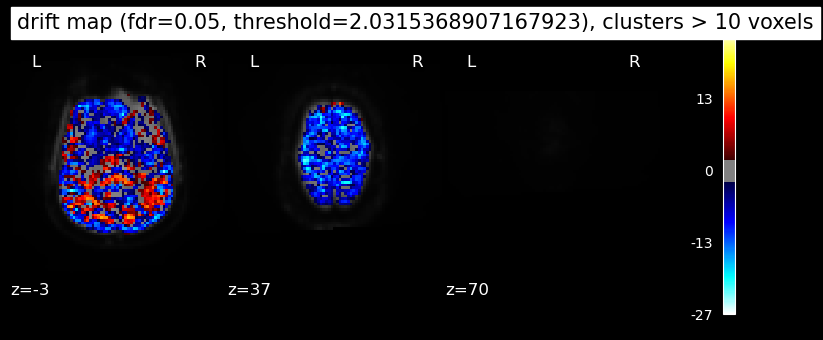

In [99]:
from nilearn.glm import threshold_stats_img

cluster_size = 10 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!


for contrast in [neg_effect,pos_effect,pos_neg,drift]:
    # Load z_map the z_map uncorrected
    file_name = namestr(contrast, globals())[0] + '_z_map_uncorrected.nii.gz'
    z_map = nib.load(os.path.join(folder_state_path, file_name))

    # FDR correction + threshold
    clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

    plot_title = namestr(contrast, globals())[0]

    plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
                display_mode='z', cut_coords=[-3,37,70], black_bg=True,
                title='{} map (fdr={}, threshold={}), clusters > {} voxels'.format(plot_title, fdr_rate, threshold, cluster_size))
    plt.show()